## Problem Statement:
The company wants to understand and process the data coming out of data engineering pipelines.The data is not cleaned & haphazard with so many raw columns:

* We are expected to Clean, sanitize and manipulate data to get useful features out of raw fields
* Make sense out of the raw data and help the data science team to build forecasting models on it

## Data Dictionary

Column Profiling:

- data - tells whether the data is testing or training data
- trip_creation_time – Timestamp of trip creation
- route_schedule_uuid – Unique Id for a particular route schedule
- route_type – Transportation type
- FTL – Full Truck Load: FTL shipments get to the destination sooner, as the truck is making no other pickups or drop-offs along the way
- Carting: Handling system consisting of small vehicles (carts)
- trip_uuid - Unique ID given to a particular trip (A trip may include different source and destination centers)
- source_center - Source ID of trip origin
- source_name - Source Name of trip origin
- destination_cente – Destination ID
- destination_name – Destination Name
- od_start_time – Trip start time
- od_end_time – Trip end time
- start_scan_to_end_scan – Time taken to deliver from source to destination
- is_cutoff – Unknown field
- cutoff_factor – Unknown field
- cutoff_timestamp – Unknown field
- actual_distance_to_destination – Distance in Kms between source and destination warehouse
- actual_time – Actual time taken to complete the delivery (Cumulative)
- osrm_time – An open-source routing engine time calculator which computes the shortest path between points in a given map (Includes usual traffic, distance through major and minor roads) and gives the time (Cumulative)
- osrm_distance – An open-source routing engine which computes the shortest path between points in a given map (Includes usual traffic, distance through major and minor roads) (Cumulative)
- factor – Unknown field
- segment_actual_time – This is a segment time. Time taken by the subset of the package delivery
- segment_osrm_time – This is the OSRM segment time. Time taken by the subset of the package delivery
- segment_osrm_distance – This is the OSRM distance. Distance covered by subset of the package delivery
- segment_factor – Unknown field

### Loading The Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import NaN, nan, NAN
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181')

In [3]:
df.shape

(144867, 24)

**Removing the columns that are taged as unknown field in data dictionary as we dont have any information about these columns and hence cant be leveraged in analysis**

In [4]:
df.drop(columns=['segment_factor','data','factor','is_cutoff', 'cutoff_factor','cutoff_timestamp',
                'route_schedule_uuid'],
       axis=1, inplace=True)

In [5]:
print('Rows:', df.shape[0],'\n' 'Columns: ',df.shape[1])

Rows: 144867 
Columns:  17


In [6]:
df.head(1)

,trip_creation_time,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance
0,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,10.43566,14.0,11.0,11.9653,14.0,11.0,11.9653


In [7]:
df.columns

Index(['trip_creation_time', 'route_type', 'trip_uuid', 'source_center',
       'source_name', 'destination_center', 'destination_name',
       'od_start_time', 'od_end_time', 'start_scan_to_end_scan',
       'actual_distance_to_destination', 'actual_time', 'osrm_time',
       'osrm_distance', 'segment_actual_time', 'segment_osrm_time',
       'segment_osrm_distance'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   trip_creation_time              144867 non-null  object 
 1   route_type                      144867 non-null  object 
 2   trip_uuid                       144867 non-null  object 
 3   source_center                   144867 non-null  object 
 4   source_name                     144574 non-null  object 
 5   destination_center              144867 non-null  object 
 6   destination_name                144606 non-null  object 
 7   od_start_time                   144867 non-null  object 
 8   od_end_time                     144867 non-null  object 
 9   start_scan_to_end_scan          144867 non-null  float64
 10  actual_distance_to_destination  144867 non-null  float64
 11  actual_time                     144867 non-null  float64
 12  osrm_time       

###  Missing Values & their treatment

In [9]:
# Function to create a data frame with number and percentage of missing data in a data frame

def missing_to_df(df):
    #Number and percentage of missing data in training data set for each column
    total_missing_df = df.isnull().sum().sort_values(ascending =False)
    percent_missing_df = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing_data_df = pd.concat([total_missing_df, percent_missing_df], axis=1, keys=['Total', 'Percent'])
    return missing_data_df

In [10]:
missing_df = missing_to_df(df)
missing_df[missing_df['Total'] > 0]

,Total,Percent
source_name,293,0.202254
destination_name,261,0.180165


- Only two fields have missing values which consists of only 0.02% of the data 
- As we have enough observations to proceed with the Analysis we will be dropping the missing values for this dataset.
Though we can treat the missing values by mean/median/mode imputation
- My reason for dropping the missing values is that I dont intent to disturb the distribution of features via imputation.

**Alternatively if missing values comprise of large part of data they can be treated using responce coding, mode, mean median imputation,
probabilistic based imputation & other forms of imputations decided by business team/ managers.**

In [11]:
#dropping the missing values
df.dropna(inplace=True)

In [12]:
d1=df.copy()

# Feature Engineering

In [13]:
d_grouped=d1.groupby(['trip_uuid','source_center','destination_center']).count().reset_index()

**Lets pick one trip_uuid to understand its journey in raw data and we will create features accrodingly**

In [14]:
d1[d1['trip_uuid']=='trip-153741093647649320']

,trip_creation_time,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance
0,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,10.435660,14.0,11.0,11.9653,14.0,11.0,11.9653
1,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,18.936842,24.0,20.0,21.7243,10.0,9.0,9.7590
2,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,27.637279,40.0,28.0,32.5395,16.0,7.0,10.8152
3,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,36.118028,62.0,40.0,45.5620,21.0,12.0,13.0224
4,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,39.386040,68.0,44.0,54.2181,6.0,5.0,3.9153
5,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),IND388320AAA,Anand_Vaghasi_IP (Gujarat),2018-09-20 04:47:45.236797,2018-09-20 06:36:55.627764,109.0,10.403038,15.0,11.0,12.1171,15.0,11.0,12.1171
6,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),IND388320AAA,Anand_Vaghasi_IP (Gujarat),2018-09-20 04:47:45.236797,2018-09-20 06:36:55.627764,109.0,18.045481,44.0,17.0,21.2890,28.0,6.0,9.1719
7,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),IND388320AAA,Anand_Vaghasi_IP (Gujarat),2018-09-20 04:47:45.236797,2018-09-20 06:36:55.627764,109.0,28.061896,65.0,29.0,35.8252,21.0,11.0,14.5362
8,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),IND388320AAA,Anand_Vaghasi_IP (Gujarat),2018-09-20 04:47:45.236797,2018-09-20 06:36:55.627764,109.0,38.939167,76.0,39.0,47.1900,10.0,10.0,11.3648
9,2018-09-20 02:35:36.476840,Carting,trip-153741093647649320,IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),IND388320AAA,Anand_Vaghasi_IP (Gujarat),2018-09-20 04:47:45.236797,2018-09-20 06:36:55.627764,109.0,43.595802,102.0,45.0,53.2334,26.0,6.0,6.0434


In [15]:
#changing datatype of date like columns from object to timestamp  
d1[["od_start_time", "od_end_time",'trip_creation_time']] = d1[["od_start_time", "od_end_time",'trip_creation_time']].apply(pd.to_datetime)

In [16]:
#extracting day, month & year from trip_creation_time 
d1['trip_creation_month']=d1['trip_creation_time'].dt.month
d1['trip_creation_year']=d1['trip_creation_time'].dt.year
d1['trip_creation_day']=d1['trip_creation_time'].dt.day

In [17]:
#difference between od_start & od_end time in hours
d1['Timediff_start_end_H']=round((d1['od_end_time']-d1['od_start_time'])/pd.Timedelta(minutes=1),2)

In [18]:
#as below mentioned columns are comprising of segment related details we will do a cum sum
d1['agg_segment_actual_time']=d1.groupby(['trip_uuid','source_center','destination_center'])['segment_actual_time'].transform('cumsum')
d1['agg_segment_osrm_time']=d1.groupby(['trip_uuid','source_center','destination_center'])['segment_osrm_time'].transform('cumsum')
d1['agg_segment_osrm_distance']=d1.groupby(['trip_uuid','source_center','destination_center'])['segment_osrm_distance'].transform('cumsum')

In [19]:
#After finding out the cumsum of above columns we will pick their max 
d1['agg_segment_actual_time1']=d1.groupby(['trip_uuid','source_center','destination_center'])['agg_segment_actual_time'].transform('max')
d1['agg_segment_osrm_time1']=d1.groupby(['trip_uuid','source_center','destination_center'])['agg_segment_osrm_time'].transform('max')
d1['agg_segment_osrm_distance1']=d1.groupby(['trip_uuid','source_center','destination_center'])['agg_segment_osrm_distance'].transform('max')

In [20]:
# aggregation of below mentioned based on their Trip_uuid, Source ID and Destination ID 
# as they are mentioned as a cumsum in data dictionary we will take max
d1['agg_distance_to_destination']=d1.groupby(['trip_uuid','source_center','destination_center'])['actual_distance_to_destination'].transform('max')
d1['agg_actual_time']=d1.groupby(['trip_uuid','source_center','destination_center'])['actual_time'].transform('max')
d1['agg_osrm_time']=d1.groupby(['trip_uuid','source_center','destination_center'])['osrm_time'].transform('max')
d1['agg_osrm_distance']=d1.groupby(['trip_uuid','source_center','destination_center'])['osrm_distance'].transform('max')

In [21]:
#creating column with city place state from source centre & destination centre
d1[['Source_City','Source_Place','Source_Code/State']]=d1['source_name'].str.rsplit('_',2, expand=True)
d1[['destination_City','destination_Place','destination_Code/State']]=d1['destination_name'].str.rsplit('_',2, expand=True)

In [22]:
#creating column with city place state from source centre & destination centre
d1[['Source_Code','Source_State']]=d1['Source_Code/State'].str.rsplit('(',2, expand=True)
d1[['destination_Code','destination_State']]=d1['destination_Code/State'].str.rsplit('(',2, expand=True)

In [23]:
#dropping the existing columns as we have already got engineered features from them
d1.drop(columns=['od_end_time','od_start_time','trip_creation_time','source_name','destination_name'],axis=1,inplace=True)

In [24]:
d1.shape

(144316, 36)

In [25]:
d1.duplicated().sum()

0

**We see there are no duplicated for now in the dataset.
The purpose of feature engineering was to create one row for one unique uuid. Lets drop those features from which we have already generated new features & again check for the duplicates.
We will definietly find duplicated now and we will remove them**

In [26]:
df_merge=d1.loc[:,['route_type', 'trip_uuid',
       'start_scan_to_end_scan',  'trip_creation_month',
       'trip_creation_year', 'trip_creation_day', 'Timediff_start_end_H', 'agg_segment_actual_time1',
       'agg_segment_osrm_time1', 'agg_segment_osrm_distance1',
       'agg_distance_to_destination', 'agg_actual_time', 'agg_osrm_time',
       'agg_osrm_distance', 'Source_City', 'Source_Place', 'Source_Code/State',
       'destination_City', 'destination_Place', 'destination_Code/State']]

In [27]:
df_merge.duplicated().sum()

118093

In [28]:
df_merge.drop_duplicates(inplace=True)

In [29]:
df_merge[df_merge['trip_uuid']=='trip-153671041653548748']

,route_type,trip_uuid,start_scan_to_end_scan,trip_creation_month,trip_creation_year,trip_creation_day,Timediff_start_end_H,agg_segment_actual_time1,agg_segment_osrm_time1,agg_segment_osrm_distance1,agg_distance_to_destination,agg_actual_time,agg_osrm_time,agg_osrm_distance,Source_City,Source_Place,Source_Code/State,destination_City,destination_Place,destination_Code/State
124981,FTL,trip-153671041653548748,999.0,9,2018,12,999.51,820.0,474.0,649.8528,440.973689,830.0,394.0,544.8027,Bhopal,Trnsport,H (Madhya Pradesh),Kanpur_Central,H,6 (Uttar Pradesh)
125002,FTL,trip-153671041653548748,1260.0,9,2018,12,1260.60,728.0,534.0,670.6205,383.759164,732.0,349.0,446.5496,Kanpur_Central,H,6 (Uttar Pradesh),Gurgaon,Bilaspur,HB (Haryana)


### Note that the above merging of rows has been performed on the basis of trip_uuid,source_centre,destination_centre

we can also further merge the rows on the basis of trip_uuid 

In [30]:
df_merge.duplicated().sum()

0

In [31]:
df_merge.shape

(26223, 20)

In [32]:
df_uuid=df_merge.copy()

In [33]:
# aggregation of below mentioned based on their Trip_uuid, Source ID and Destination ID 
# as they are mentioned as a cumsum in data dictionary we will take max
df_uuid['start_scan_to_end_scan11']=df_uuid.groupby(['trip_uuid'])['start_scan_to_end_scan'].transform('sum')
df_uuid['Timediff_start_end_H11']=df_uuid.groupby(['trip_uuid'])['Timediff_start_end_H'].transform('sum')
df_uuid['agg_segment_actual_time11']=df_uuid.groupby(['trip_uuid'])['agg_segment_actual_time1'].transform('sum')
df_uuid['agg_segment_osrm_time11']=df_uuid.groupby(['trip_uuid'])['agg_segment_osrm_time1'].transform('sum')

df_uuid['agg_segment_osrm_distance11']=df_uuid.groupby(['trip_uuid'])['agg_segment_osrm_distance1'].transform('sum')
df_uuid['agg_distance_to_destination11']=df_uuid.groupby(['trip_uuid'])['agg_distance_to_destination'].transform('sum')
df_uuid['agg_actual_time11']=df_uuid.groupby(['trip_uuid'])['agg_actual_time'].transform('sum')
df_uuid['agg_osrm_time11']=df_uuid.groupby(['trip_uuid'])['agg_osrm_time'].transform('sum')
df_uuid['agg_osrm_distance11']=df_uuid.groupby(['trip_uuid'])['agg_osrm_distance'].transform('sum')

df_uuid['Source_City11']=df_uuid.groupby(['trip_uuid'])['Source_City'].transform('first')
df_uuid['Source_Place11']=df_uuid.groupby(['trip_uuid'])['Source_Place'].transform('first')
df_uuid['Source_Code/State11']=df_uuid.groupby(['trip_uuid'])['Source_Code/State'].transform('first')
df_uuid['destination_City11']=df_uuid.groupby(['trip_uuid'])['destination_City'].transform('last')
df_uuid['destination_Place11']=df_uuid.groupby(['trip_uuid'])['destination_Place'].transform('last')
df_uuid['destination_Code/State11']=df_uuid.groupby(['trip_uuid'])['destination_Code/State'].transform('last')

In [34]:
df1=df_uuid.loc[:,['route_type', 'trip_uuid',
        'trip_creation_month', 'trip_creation_year', 'trip_creation_day',
       'start_scan_to_end_scan11', 'Timediff_start_end_H11',
       'agg_segment_actual_time11', 'agg_segment_osrm_time11',
       'agg_segment_osrm_distance11', 'agg_distance_to_destination11',
       'agg_actual_time11', 'agg_osrm_time11', 'agg_osrm_distance11',
       'Source_City11', 'Source_Place11', 'Source_Code/State11',
       'destination_City11', 'destination_Place11',
       'destination_Code/State11']]

In [35]:
df1.duplicated().sum()

11436

In [36]:
#before merging checking 1 unique uuid for cross check purpose
df1[df1['trip_uuid']=='trip-153671041653548748']

,route_type,trip_uuid,trip_creation_month,trip_creation_year,trip_creation_day,start_scan_to_end_scan11,Timediff_start_end_H11,agg_segment_actual_time11,agg_segment_osrm_time11,agg_segment_osrm_distance11,agg_distance_to_destination11,agg_actual_time11,agg_osrm_time11,agg_osrm_distance11,Source_City11,Source_Place11,Source_Code/State11,destination_City11,destination_Place11,destination_Code/State11
124981,FTL,trip-153671041653548748,9,2018,12,2259.0,2260.11,1548.0,1008.0,1320.4733,824.732854,1562.0,743.0,991.3523,Bhopal,Trnsport,H (Madhya Pradesh),Gurgaon,Bilaspur,HB (Haryana)
125002,FTL,trip-153671041653548748,9,2018,12,2259.0,2260.11,1548.0,1008.0,1320.4733,824.732854,1562.0,743.0,991.3523,Bhopal,Trnsport,H (Madhya Pradesh),Gurgaon,Bilaspur,HB (Haryana)


In [37]:
df1.drop_duplicates(inplace=True)

In [38]:
df1.duplicated().sum()

0

In [39]:
df1.shape

(14787, 20)

So after the entire merging the final dataset that has been created with multiple induced features and distict rows has:
* **14787 rows**
* **20 columns**

## Comparing the difference between time taken between od_start_time and od_end_time and start_scan_to_end_scan. 

In [40]:
df1['scan_diff_check']=df1['Timediff_start_end_H11']-df1['start_scan_to_end_scan11']

In [41]:
#checking if there is any value where difference is > 1 min
# df1[df1['scan_diff_check']>1]

### Visualising the Difference between the two start_scan_to_end_scan & Timediff_start_end_H:

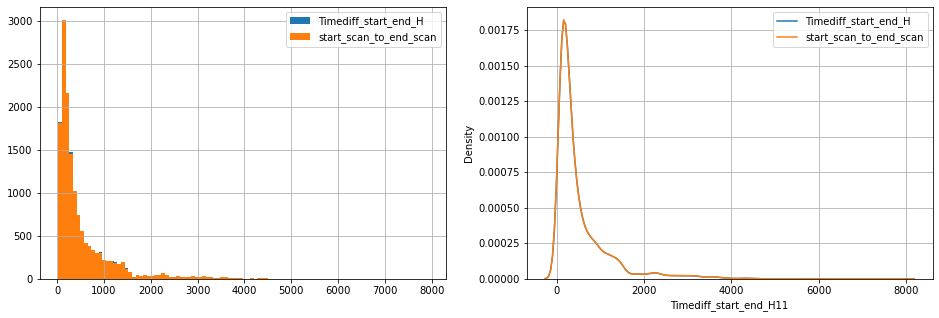

In [42]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(df1['Timediff_start_end_H11'],bins=100,label='Timediff_start_end_H')
plt.hist(df1['start_scan_to_end_scan11'],bins=100,label='start_scan_to_end_scan')
plt.legend()
plt.grid()
plt.subplot(122)
sns.kdeplot(df1['Timediff_start_end_H11'],label='Timediff_start_end_H')
sns.kdeplot(df1['start_scan_to_end_scan11'],label='start_scan_to_end_scan')
plt.legend()
plt.grid()
plt.show()

* As We can clearly see both the curves are overlapping which means **they are fairly same.**

### Now lets proof the above comparision using hypothesis Testing

### Defining Null & Alternate Hypothesis

* 𝐻0 : μ𝑎 = μ𝑜 the mean for Timediff_start_end_H & start_scan_to_end_scan are same
* 𝐻𝑎 : μ𝑎 > μ𝑜 the mean for start_scan_to_end_scan is more than start_scan_to_end_scan



### Defining T-statistics:
We will perform 2 tailed test as variance of the population is not known

In order to test them we shall run a one-tailed t-test using an arbitrated α level of 0.05

* α =0.05

In [43]:
def htResult(p_value):
    significance_level = 0.05
    if p_value <= significance_level: 
        print('Reject NULL HYPOTHESIS') 
    else: 
        print('Fail to Reject NULL HYPOTHESIS')

In [44]:
import scipy.stats as stats
st,p = stats.ttest_ind(df1['Timediff_start_end_H11'],df1['start_scan_to_end_scan11'])
print('P-value :',(p/2))

htResult(p/2)

P-value : 0.45401740157102755
Fail to Reject NULL HYPOTHESIS


* As p value> alpha We fail so reject the null hypothesis @ there is no mean difference between start_end_H and start_scan_to_end_scan 

# Visual analysis

### Comparision Between Aggregate Actual time & Aggregate OSRM Time

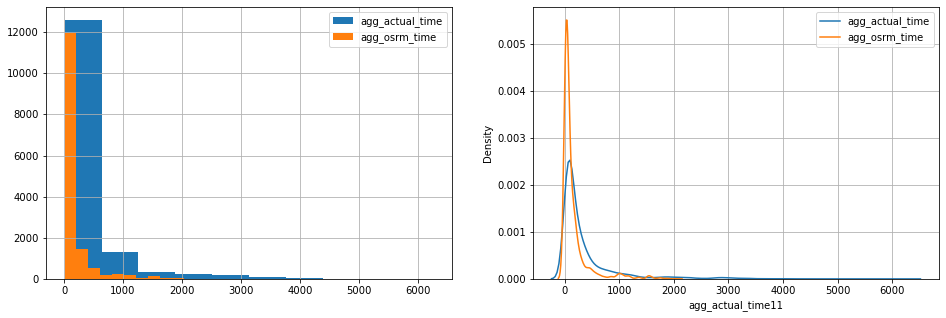

In [45]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(df1['agg_actual_time11'],bins=10,label='agg_actual_time')
plt.hist(df1['agg_osrm_time11'],bins=10,label='agg_osrm_time')
plt.legend()
plt.grid()
plt.subplot(122)
sns.kdeplot(df1['agg_actual_time11'],label='agg_actual_time')
sns.kdeplot(df1['agg_osrm_time11'],label='agg_osrm_time')
plt.legend()
plt.grid()
plt.show()

* Clearly visible, agg_actual_time is somewhat greater than agg_osrm_time and which is intutive as well

### Comparision Between Aggregate OSRM distance & Aggregate Segment osrm distance

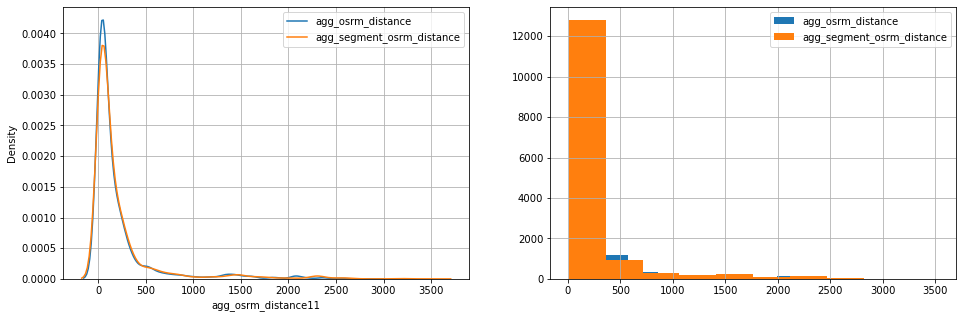

In [46]:
plt.figure(figsize=(16,5))
plt.subplot(121)
sns.kdeplot(df1['agg_osrm_distance11'],label='agg_osrm_distance')
sns.kdeplot(df1['agg_segment_osrm_distance11'],label='agg_segment_osrm_distance')
plt.legend()
plt.grid()
plt.subplot(122)
plt.hist(df1['agg_osrm_distance11'],bins=10,label='agg_osrm_distance')
plt.hist(df1['agg_segment_osrm_distance11'],bins=10,label='agg_segment_osrm_distance')
plt.legend()
plt.grid()
plt.show()

* Clearly visible there is a overlap between both the variables which suggests segment distances & agg distances are almost same

### Comparision Between Aggregate Actual time & Aggregate segment_actual_time

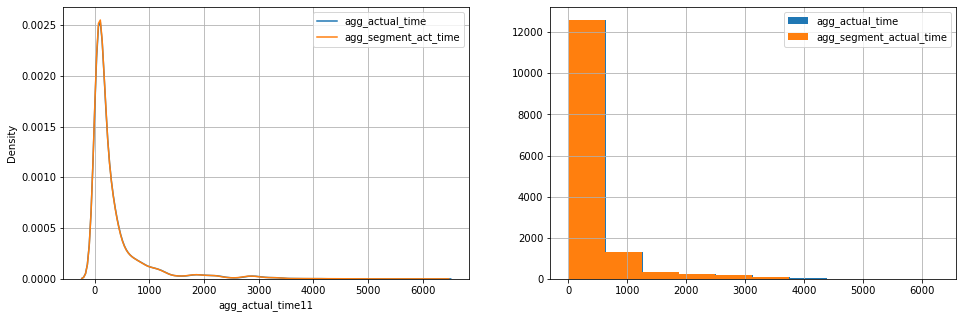

In [47]:
plt.figure(figsize=(16,5))
plt.subplot(121)
sns.kdeplot(df1['agg_actual_time11'],label='agg_actual_time')
sns.kdeplot(df1['agg_segment_actual_time11'],label='agg_segment_act_time')
plt.legend()
plt.grid()
plt.subplot(122)
plt.hist(df1['agg_actual_time11'],bins=10,label='agg_actual_time')
plt.hist(df1['agg_segment_actual_time11'],bins=10,label='agg_segment_actual_time')
plt.legend()
plt.grid()
plt.show()

* Clearly visible there is a overlap between both the variables which suggests segment distances & agg distances are almost same

### Comparision Between Aggregate OSRM time & Aggregate Segment OSRM Time

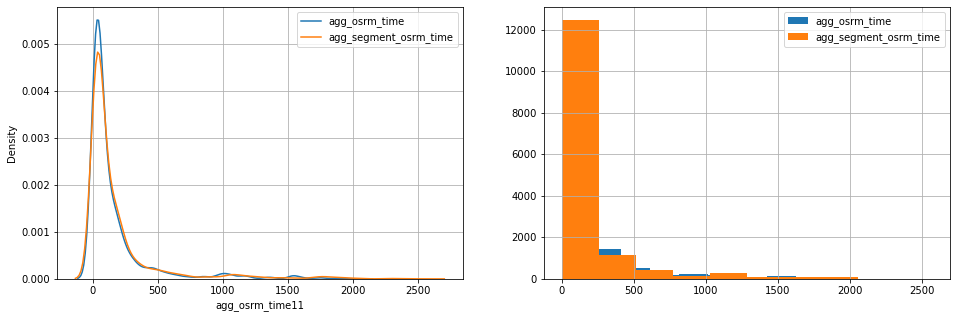

In [48]:
plt.figure(figsize=(16,5))
plt.subplot(121)
sns.kdeplot(df1['agg_osrm_time11'],label='agg_osrm_time')
sns.kdeplot(df1['agg_segment_osrm_time11'],label='agg_segment_osrm_time')
plt.legend()
plt.grid()
plt.subplot(122)
plt.hist(df1['agg_osrm_time11'],bins=10,label='agg_osrm_time')
plt.hist(df1['agg_segment_osrm_time11'],bins=10,label='agg_segment_osrm_time')
plt.legend()
plt.grid()
plt.show()

* Clearly visible there is a overlap between both the variables which suggests osrm time & segment osrm times are almost same

## Now lets do some hypothesis testing on the above comparisions:

### Hypothesis test of mean difference of Agg_actual_time & agg_osrm_time

**Defining Null & Alternate Hypothesis**

* $H_0$ : $μ_a$ = $μ_o$ the mean for agg_Actual_time & agg_osrm_time are same
* $H_a$ : $μ_a$ > $μ_o$ the mean for agg_Actual_time is more than agg_osrm_time

In order to test them we shall run a one-tailed t-test using an arbitrated  α  level of  0.05
* α =0.05

In [49]:
import scipy.stats as stats
st,p = stats.ttest_ind(df1['agg_actual_time11'],df1['agg_osrm_time11'])
print('P-value :',(p/2))

htResult(p/2)

P-value : 1.1794664115414192e-307
Reject NULL HYPOTHESIS


* As **p< α** we have enough evidence to reject the null hypothesis @ there is a difference between the mean for agg_Actual_time & agg_osrm_time

### Hypothesis test of mean difference of Agg_actual_time & agg_segment_actual_time

* $H_0$ : $μ_a$ = $μ_o$ the mean for agg_Actual_time & agg_segment_actual_time are same
* $H_a$ : $μ_a$ > $μ_o$ the mean for agg_Actual_time & agg_segment_actual_time are different

In [50]:
import scipy.stats as stats
st,p = stats.ttest_ind(df1['agg_actual_time11'],df1['agg_segment_actual_time11'])
print('P-value :',(p/2))

htResult(p/2)

P-value : 0.30929173856919245
Fail to Reject NULL HYPOTHESIS


* As **p> α** we have enough evidence to reject the null hypothesis @ there is a difference between the mean for agg_Actual_time & agg_segment_actual_time

### Hypothesis test of mean difference of Agg_osrm_distance & agg_segment_osrm_distance

* $H_0$ : $μ_a$ = $μ_o$ the mean for Agg_osrm_distance & agg_segment_osrm_distance are same
* $H_a$ : $μ_a$ > $μ_o$ the mean for Agg_osrm_distance & agg_segment_osrm_distance are different

In [51]:
import scipy.stats as stats
st,p = stats.ttest_ind(df1['agg_osrm_distance11'],df1['agg_segment_osrm_distance11'])
print('P-value :',(p/2))

htResult(p/2)

P-value : 4.1180380871906024e-05
Reject NULL HYPOTHESIS


* As **p< α** we have enough evidence to reject the null hypothesis @ there is no difference between the mean for Agg_osrm_distance & agg_segment_osrm_distance

# Exploratory Data Analysis

### Univariate Data Analysis

In [52]:
num_cols = df.select_dtypes('float64').columns.values
cat_cols = df1.select_dtypes('object').columns.values

In [53]:
num_cols=df1.select_dtypes('float64').columns.values
for i in num_cols:
    print('##############')
    print(df1[i].value_counts())

##############
115.0     51
148.0     51
87.0      50
128.0     49
113.0     49
          ..
2528.0     1
2057.0     1
3442.0     1
3158.0     1
2150.0     1
Name: start_scan_to_end_scan11, Length: 2203, dtype: int64
##############
319.61    4
124.71    4
147.10    4
146.19    4
122.43    4
         ..
381.11    1
141.06    1
37.91     1
212.07    1
170.46    1
Name: Timediff_start_end_H11, Length: 13592, dtype: int64
##############
47.0      121
41.0      112
60.0      107
55.0      100
35.0      100
         ... 
2848.0      1
2233.0      1
3228.0      1
1657.0      1
2291.0      1
Name: agg_segment_actual_time11, Length: 1885, dtype: int64
##############
17.0      221
20.0      213
19.0      210
18.0      209
22.0      208
         ... 
1822.0      1
437.0       1
1415.0      1
1099.0      1
1250.0      1
Name: agg_segment_osrm_time11, Length: 1240, dtype: int64
##############
66.9731     2
21.5174     2
35.4104     2
37.2206     2
24.1684     2
           ..
236.8402    1
71.6018  

In [54]:
for i in cat_cols:
    print('##############')
    print(df1[i].value_counts())

##############
Carting    8906
FTL        5881
Name: route_type, dtype: int64
##############
trip-153766197910385909    1
trip-153800058441560942    1
trip-153817438822669272    1
trip-153765654337374164    1
trip-153671803100571827    1
                          ..
trip-153722841760609653    1
trip-153843853071787350    1
trip-153712984135936443    1
trip-153779380231643671    1
trip-153739705199482125    1
Name: trip_uuid, Length: 14787, dtype: int64
##############
Bengaluru            1014
Gurgaon              1011
Bhiwandi              811
Bangalore             731
Delhi                 617
                     ... 
Bheemunipatnam          1
Machhiwara              1
Vikarabad_Central       1
Nagaur                  1
Bidar (Karnataka)       1
Name: Source_City11, Length: 706, dtype: int64
##############
Bilaspur    959
Mankoli     811
Nelmngla    732
H           643
I           571
           ... 
SaiBansi      1
Sadras        1
DltprDPP      1
VasaviNg      1
NrdawDPP      1
Name

### Lets try to find Bussiest Corridor

In [55]:
d_grouped.route_type.max()

81

In [56]:
# find trip uuid of max count
d_grouped[d_grouped['route_type']==81]

df[df['trip_uuid']=='trip-153755502932196495']

,trip_creation_time,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance
61008,2018-09-21 18:37:09.322207,FTL,trip-153755502932196495,IND160002AAC,Chandigarh_Mehmdpur_H (Punjab),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),2018-09-21 18:37:09.322207,2018-09-24 09:59:15.691618,3802.0,22.574426,61.0,33.0,30.9712,61.0,33.0,30.9712
61009,2018-09-21 18:37:09.322207,FTL,trip-153755502932196495,IND160002AAC,Chandigarh_Mehmdpur_H (Punjab),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),2018-09-21 18:37:09.322207,2018-09-24 09:59:15.691618,3802.0,188.713089,277.0,190.0,215.9518,216.0,157.0,184.9805
61010,2018-09-21 18:37:09.322207,FTL,trip-153755502932196495,IND160002AAC,Chandigarh_Mehmdpur_H (Punjab),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),2018-09-21 18:37:09.322207,2018-09-24 09:59:15.691618,3802.0,200.615452,289.0,199.0,228.2893,11.0,8.0,12.3376
61011,2018-09-21 18:37:09.322207,FTL,trip-153755502932196495,IND160002AAC,Chandigarh_Mehmdpur_H (Punjab),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),2018-09-21 18:37:09.322207,2018-09-24 09:59:15.691618,3802.0,223.377051,313.0,216.0,253.0804,24.0,17.0,24.7911
61012,2018-09-21 18:37:09.322207,FTL,trip-153755502932196495,IND160002AAC,Chandigarh_Mehmdpur_H (Punjab),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),2018-09-21 18:37:09.322207,2018-09-24 09:59:15.691618,3802.0,246.271125,338.0,235.0,280.2487,24.0,19.0,27.1683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61084,2018-09-21 18:37:09.322207,FTL,trip-153755502932196495,IND160002AAC,Chandigarh_Mehmdpur_H (Punjab),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),2018-09-21 18:37:09.322207,2018-09-24 09:59:15.691618,3802.0,1853.249750,3508.0,1629.0,2245.3849,23.0,24.0,28.0373
61085,2018-09-21 18:37:09.322207,FTL,trip-153755502932196495,IND160002AAC,Chandigarh_Mehmdpur_H (Punjab),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),2018-09-21 18:37:09.322207,2018-09-24 09:59:15.691618,3802.0,1876.975233,3532.0,1650.0,2275.5970,24.0,21.0,30.2121
61086,2018-09-21 18:37:09.322207,FTL,trip-153755502932196495,IND160002AAC,Chandigarh_Mehmdpur_H (Punjab),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),2018-09-21 18:37:09.322207,2018-09-24 09:59:15.691618,3802.0,1901.686641,3556.0,1664.0,2294.8983,23.0,20.0,26.0819
61087,2018-09-21 18:37:09.322207,FTL,trip-153755502932196495,IND160002AAC,Chandigarh_Mehmdpur_H (Punjab),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),2018-09-21 18:37:09.322207,2018-09-24 09:59:15.691618,3802.0,1924.221719,3580.0,1682.0,2319.9344,24.0,17.0,25.0360


In [57]:
df1[df1['trip_uuid']=='trip-153755502932196495'][['agg_segment_actual_time11',
       'agg_segment_osrm_time11', 'agg_segment_osrm_distance11',
       'agg_distance_to_destination11', 'agg_actual_time11', 'agg_osrm_time11']]

,agg_segment_actual_time11,agg_segment_osrm_time11,agg_segment_osrm_distance11,agg_distance_to_destination11,agg_actual_time11,agg_osrm_time11
61008,3751.0,1864.0,2500.2145,1927.447705,3784.0,1686.0


* Bussiest Corridor is from source Chandigarh_Mehmdpur_H (Punjab) to Bangalore_Nelmngla_H (Karnataka)
  Average_distance between them is 1927 kms & average time taken is 3784 mins

In [58]:
l=['start_scan_to_end_scan11',
       'trip_creation_day', 'Timediff_start_end_H11', 'agg_segment_actual_time11',
       'agg_segment_osrm_time11', 'agg_segment_osrm_distance11',
       'agg_distance_to_destination11', 'agg_actual_time11', 'agg_osrm_time11',
       'agg_osrm_distance11']

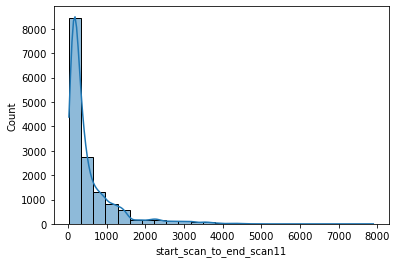

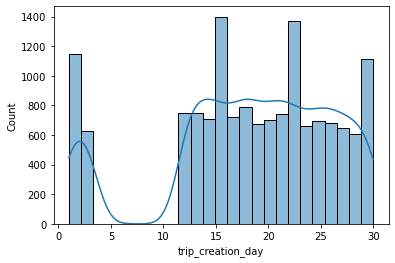

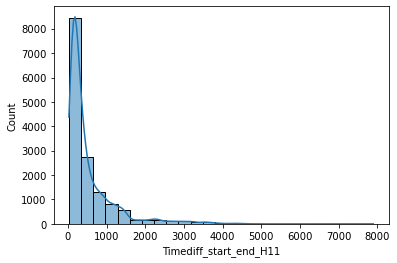

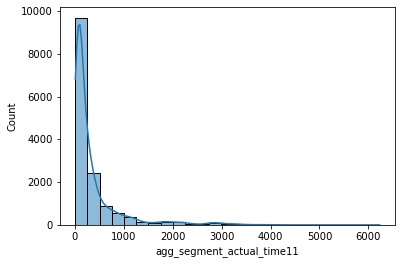

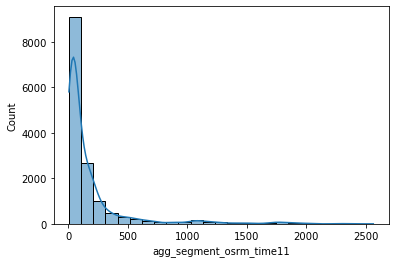

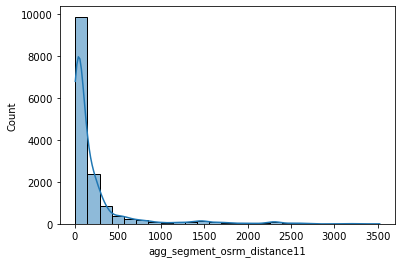

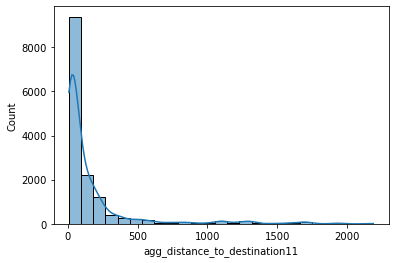

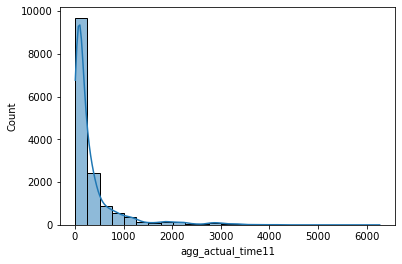

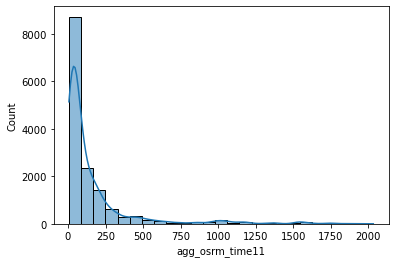

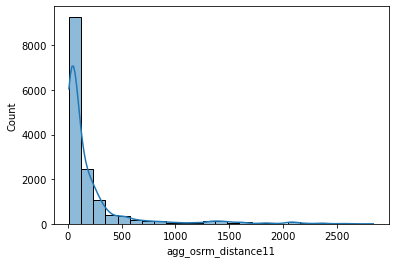

In [59]:
for i in l:
    sns.histplot(data = df1, x = df1[i],bins = 25,kde=True)
    plt.show()

* The entire data is heavily right skewed

## Outlier Detection & their Treatment

In [60]:
def uni(d):
    f,ax = plt.subplots(nrows=1,ncols=2,figsize=(7,3))
    sns.histplot(d, kde=True, ax=ax[0])
    ax[0].axvline(d.mean(), color='y', linestyle='--',linewidth=2)
    ax[0].axvline(d.median(), color='r', linestyle='dashed', linewidth=2)
    ax[0].axvline(d.mode()[0],color='g',linestyle='solid',linewidth=2)
    ax[0].legend({'Mean':d.mean(),'Median':d.median(),'Mode':d.mode()})
    
    sns.boxplot(x=d, showmeans=True, ax=ax[1])
    plt.tight_layout()

In [61]:
num_cols = df.select_dtypes('float64').columns.values

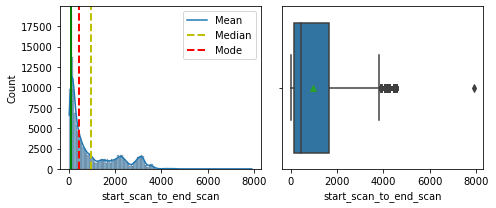

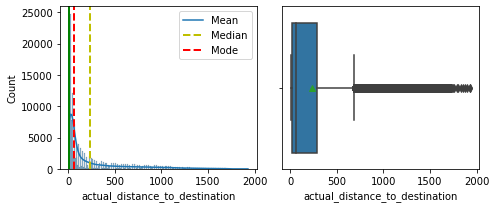

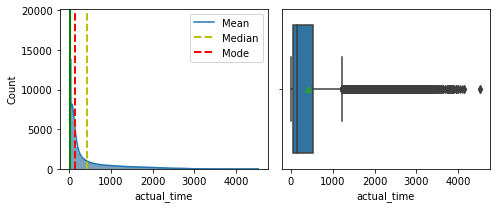

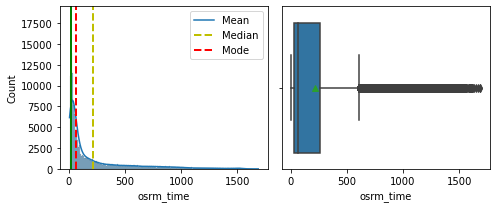

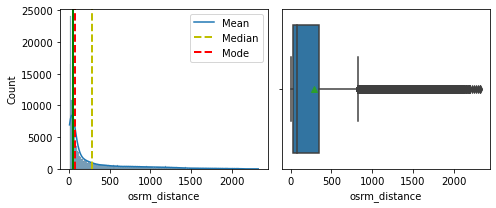

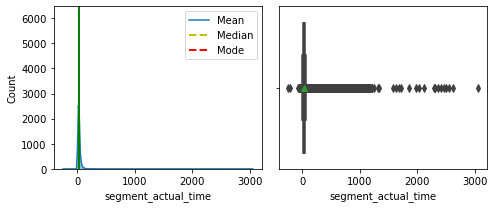

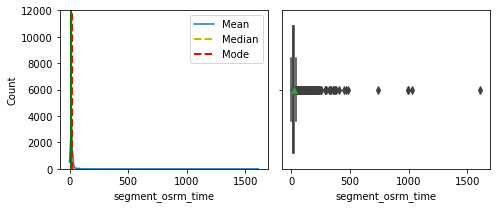

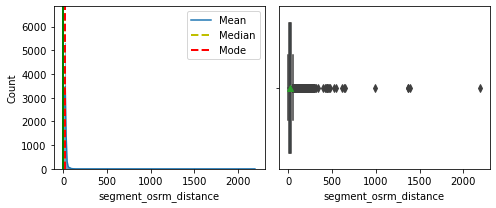

In [62]:
for f in num_cols:
    uni(df[f])
plt.show()

* There are outliers in almost all of the numeric feature

In [63]:
#treating outliers:
def treat_outlier(variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1,q3=np.percentile(variable,[25,75])
    iqr = q3-q1
    lo_range = q1-(1.5*iqr)
    up_range = q3+(1.5*iqr)
    return lo_range,up_range


In [64]:
for col in num_cols:
    ir,ur=treat_outlier(df[col])
    df[col]=np.where(df[col]>ur,ur,df[col])
    df[col]=np.where(df[col]<ir,ir,df[col])

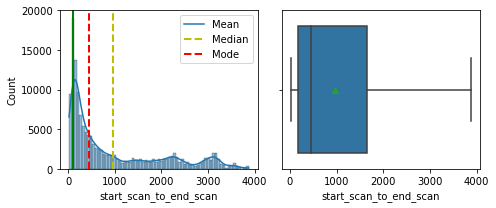

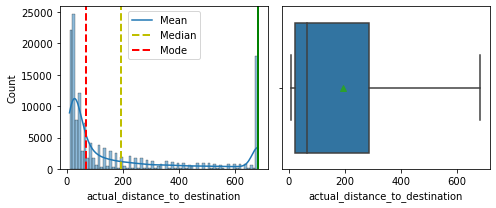

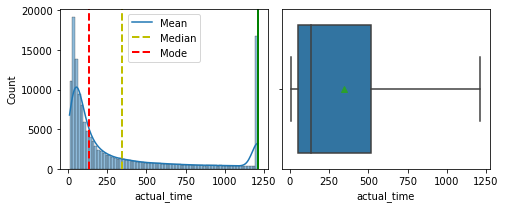

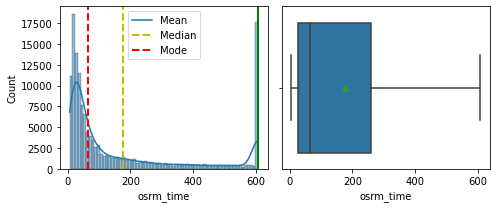

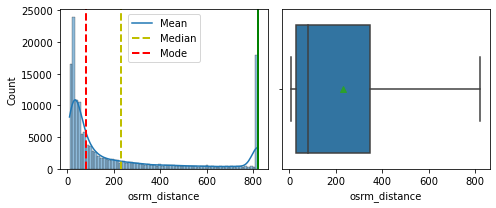

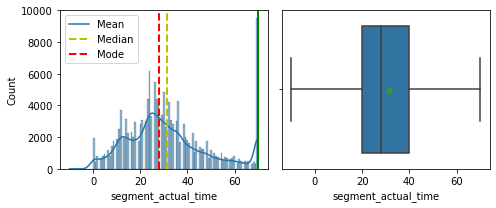

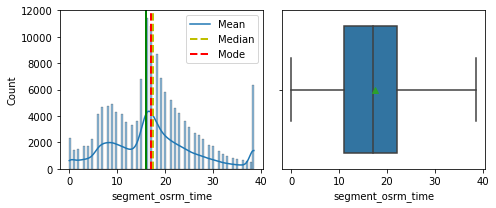

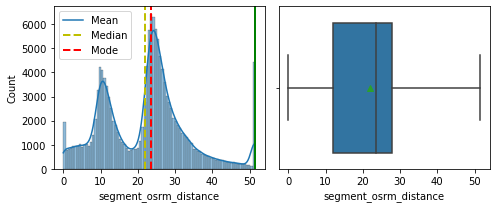

In [65]:
#Lets check where outliers are removed or not:
for f in num_cols:
    uni(df[f])
plt.show()

Outliers are removed

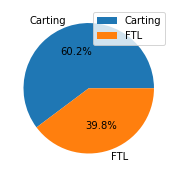

In [66]:
fig1, ax1 = plt.subplots(figsize=(7,3))
ax1.pie(df1['route_type'].value_counts(), labels=df['route_type'].unique(), autopct='%1.1f%%')
plt.legend()
plt.show()

* 60% data is from Carting rout_type & the remaining 40% is from FTL

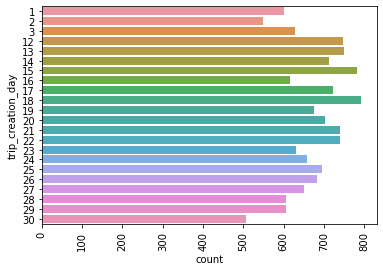

In [67]:
sns.countplot(y=df1['trip_creation_day'])
plt.xticks(rotation=90)
plt.show()

* Start & End dates of the months have less percent of trips compare to mid of the month. Though the difference is not huge 
* Thats very strange to see that there is absolutely no trip from 4th- 11th day of the month

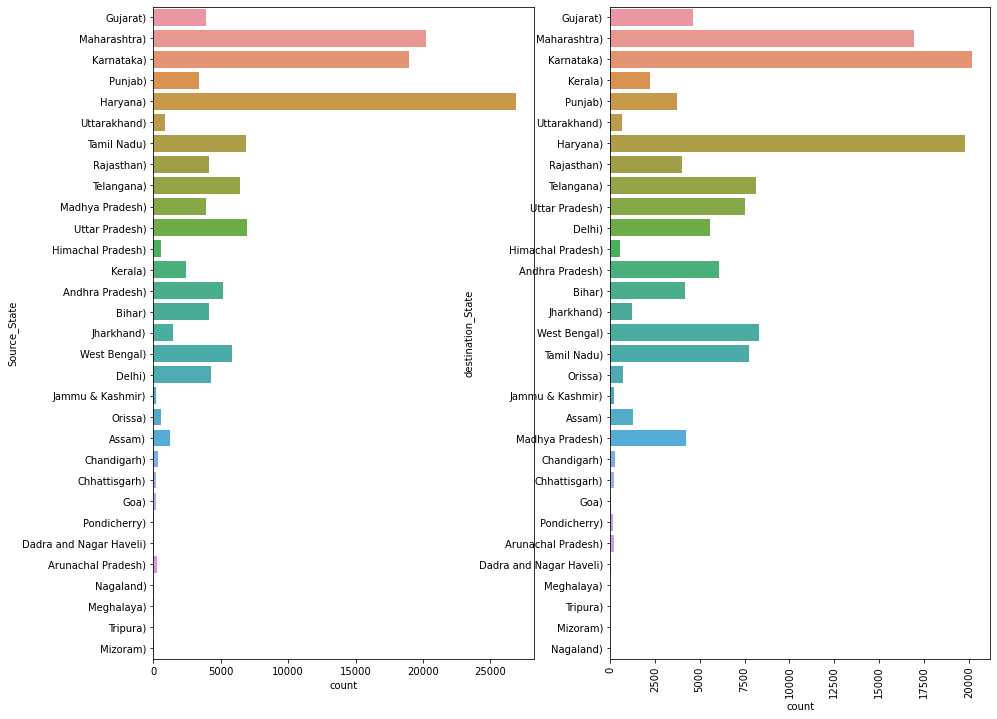

<Figure size 432x288 with 0 Axes>

In [68]:
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,12))
sns.countplot(y=d1['Source_State'],ax=ax[0])
sns.countplot(y=d1['destination_State'],ax=ax[1])

plt.xticks(rotation=90)
plt.show()
plt.tight_layout()

* Most of the orders are coming from/reaching to Maharashtra followed by Karnataka
* Least orders are coming from/reaching to Seven Sisters(NE states)


# Bivariate Analysis

In [69]:
lk=df1.loc[:,['route_type', 'trip_uuid',
       'start_scan_to_end_scan11', 'trip_creation_month',
       'trip_creation_day', 'Timediff_start_end_H11', 'agg_segment_actual_time11',
       'agg_segment_osrm_time11', 'agg_segment_osrm_distance11',
       'agg_distance_to_destination11', 'agg_actual_time11', 'agg_osrm_time11',
       'agg_osrm_distance11', 'Source_City11', 'Source_Place11', 'Source_Code/State11',
       'destination_City11', 'destination_Place11', 'destination_Code/State11']]

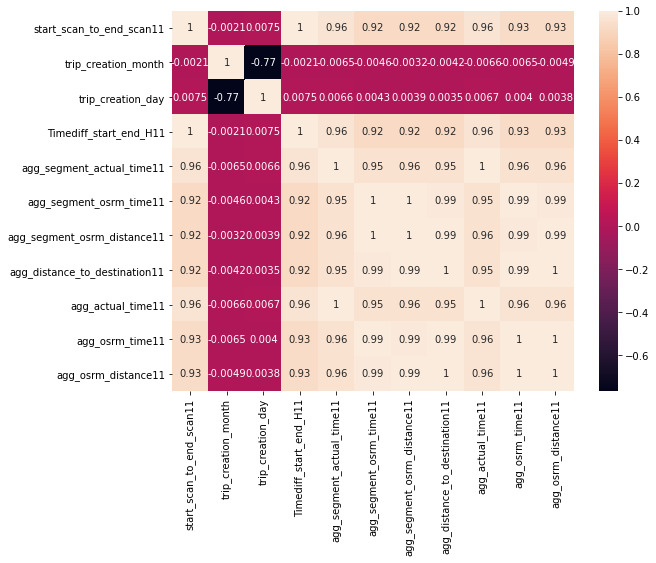

In [70]:
plt.figure(figsize = (9, 7))
sns.heatmap(lk.corr(),annot=True)
plt.show()

* Almost all the features are heavy positively correleated with each other & which is intutive as well.
* There is a high -ve correlation between almost all the other features & trip_creation_month

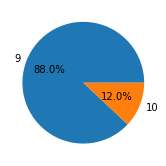

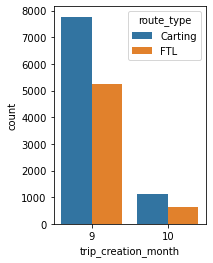

In [71]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
ax1.pie(df1['trip_creation_month'].value_counts(), labels=df1['trip_creation_month'].unique(), autopct='%1.1f%%')
plt.show()
fig2 = plt.figure()
ax2 = fig2.add_subplot(122)
sns.countplot(df1['trip_creation_month'], hue=df1['route_type'])
plt.show()

* 88% of the trips are from October Month & remaining are from November

## One Hot Encoding of Categorical Features

In [72]:
#Oone hot endoing of rout_type columns:
mod_df=pd.concat([df1,pd.get_dummies(df1['route_type'])],axis=1)

In [73]:
#dropping the original column
mod_df.drop(['route_type'],axis=1, inplace=True)

In [74]:
mod_df.head(2)

,trip_uuid,trip_creation_month,trip_creation_year,trip_creation_day,start_scan_to_end_scan11,Timediff_start_end_H11,agg_segment_actual_time11,agg_segment_osrm_time11,agg_segment_osrm_distance11,agg_distance_to_destination11,...,agg_osrm_distance11,Source_City11,Source_Place11,Source_Code/State11,destination_City11,destination_Place11,destination_Code/State11,scan_diff_check,Carting,FTL
0,trip-153741093647649320,9,2018,20,195.0,195.38,167.0,88.0,102.7106,82.981842,...,107.4515,Anand,VUNagar,DC (Gujarat),Anand,Vaghasi,IP (Gujarat),0.38,1,0
10,trip-153768492602129387,9,2018,23,302.0,302.37,180.0,106.0,130.4089,100.708423,...,129.3519,Bhiwandi,Mankoli,HB (Maharashtra),Pune,Tathawde,H (Maharashtra),0.37,0,1


### Dealing with high Cardinality in Categorical Feature
* Some of the features are having high cardinality like source_city, source_place etc:

**A categorical feature is said to possess high cardinality when there are too many of these unique values. One-Hot Encoding becomes a big problem in such a case since we have a separate column for each unique value (indicating its presence or absence) in the categorical variable.** 

Reducing Cardinality by using a simple Aggregating function
Below is a simple function I use to reduce the cardinality of a feature. The idea is very simple. Leave instances belonging to a value with high frequency as they are and replace the other instances with a new category which we will call other.

Choose a threshold
Sort unique values in the column by their frequency in descending order
Keep adding the frequency of these sorted (descending) unique values until a threshold is reached.
These are the unique categories we will keep and instances of all other categories shall be replaced by “other”.

**I am leaving that part for now as it is beyond the scope of this case study!**

## Column Standarization and Normalization
- Mean centering and Variance scaling (Standard Scaling)
- MinMax Scaling



In [75]:
st_df=df1.loc[:,['start_scan_to_end_scan11', 'trip_creation_month',
       'trip_creation_day', 'Timediff_start_end_H11', 'agg_segment_actual_time11',
       'agg_segment_osrm_time11', 'agg_segment_osrm_distance11',
       'agg_distance_to_destination11', 'agg_actual_time11', 'agg_osrm_time11',
       'agg_osrm_distance11']]

In [76]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
std_data = scaler.fit_transform(st_df)
std_data = pd.DataFrame(std_data, columns=st_df.columns)
std_data.head()


,start_scan_to_end_scan11,trip_creation_month,trip_creation_day,Timediff_start_end_H11,agg_segment_actual_time11,agg_segment_osrm_time11,agg_segment_osrm_distance11,agg_distance_to_destination11,agg_actual_time11,agg_osrm_time11,agg_osrm_distance11
0,-0.508068,-0.369459,0.206152,-0.508710,-0.334451,-0.294009,-0.287886,-0.266017,-0.331816,-0.266786,-0.262008
1,-0.345519,-0.369459,0.586769,-0.346216,-0.311086,-0.236806,-0.221437,-0.208024,-0.308664,-0.244759,-0.202967
2,-0.640233,-0.369459,-0.555083,-0.639932,-0.526766,-0.522820,-0.489205,-0.483739,-0.527715,-0.534777,-0.501015
3,0.761939,-0.369459,-0.681955,0.761412,0.801464,1.021659,0.810392,0.677742,0.799061,1.190646,0.862876
4,-0.407804,-0.369459,1.348004,-0.406557,-0.363209,-0.138290,-0.256604,-0.225101,-0.363872,-0.141968,-0.218028


# Insights:

**Based on EDA:**
* The entire data is heavily right skewed
* Almost all the features are heavy positively correleated with each other & which is intutive as well.
* There is a high -ve correlation between almost all the other features & trip_creation_month
* 60% data is from Carting rout_type & the remaining 40% is from FTL
* 88% of the trips are from October Month & remaining are from November
* Start & End dates of the months have less percent of trips compare to mid of the month. Though the difference is not huge
* Thats very strange to see that there is absolutely no trip from 4th- 11th day of the month
* Most of the orders are coming from Maharashtra followed by Karnataka
* Least orders are coming from Seven Sisters(NE states)
* Bussiest Corridor is from source Chandigarh_Mehmdpur_H (Punjab) to Bangalore_Nelmngla_H (Karnataka) Average_osrm_distance between them is 2500 kms & average time taken is 3784 mins

**Based on Hypothesis Testing:**
* There is no difference in the population means of time taken between od_start_time and od_end_time  and start_scan_to_end_scan 
* There is a difference between the population means of agg_Actual_time & agg_osrm_time. Mean of 
  agg_Actual_time is bigger than that of agg_osrm_time
* There is a difference between the population means of agg_Actual_time & agg_segment_actual_time.       Mean of agg_Actual_time is bigger than that of agg_segment_actual_time
* There is a difference between the population means of agg_osrm_distance & agg_segment_osrm_distance. 
* There is a difference between the population means of osrm_time & segment_osrm_time.     

# Recommendations:

* As its depicted from the analysis that there is absolutely no trip from 4th- 11th day of the month,
  The reason for that can be figured out and catered to receive the orders in the these dates as well.
* Least orders are reaching/coming from North East states, more corridors/campaigns can be promoted to penetrate in these states as well.
* Most of the orders are coming from/reaching to Maharashtra & Karnataka, existing corridors can be further enhanced to maintain the penetration from these areas.Also a further profiling of these orders can be made from more rich data to get to know why major orders are coming from these corridors
* FTL route consists of 40% of the total orders. More ways to promote FTL route handling system can be implemented to increase this percentage
